In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df = pd.concat([df, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')], ignore_index=True) 

In [3]:
df_bin = df.copy()
df_bin.labels = df.labels.replace([2, 3, 4], 1)

In [4]:
labels_bin = df_bin.labels

In [5]:
features = df.iloc[:, :-2]
labels = df.labels

In [6]:
features

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk
0,1143.592529,0.039967,146.150787,0.525687,0.505117,38,48,-27.057099,-23.003627
1,1476.433716,1.387635,14.246826,-1.370057,0.113648,21,33,-47.325838,-42.513492
2,1540.057007,1.520813,94.611481,1.142746,-0.478356,46,31,-22.852907,-45.262825
3,1533.117432,1.955224,79.998779,-0.021801,1.994529,46,37,-22.796860,-39.182772
4,1164.201416,0.747826,97.815399,-0.216873,0.608687,40,45,-25.285624,-26.312875
...,...,...,...,...,...,...,...,...,...
2067579,2686.224854,1.818661,211.678955,0.903337,-0.919513,58,129,-16.311280,44.333506
2067580,2692.715088,0.938040,136.215576,0.324722,-0.615071,78,78,3.673315,-6.691277
2067581,2476.301514,0.264742,106.248535,0.488685,0.740875,200,96,126.251694,12.251655
2067582,2140.740234,1.310556,192.544434,-0.370099,0.945993,134,99,61.481212,17.241032


In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
_, _, y_train_bin, y_test_bin = train_test_split(features, labels_bin, test_size=0.2, random_state=42)

In [8]:
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_test_control_bin = y_test_bin[x_test_control.index]
y_train_control = y_train[x_train_control.index]
y_train_control_bin = y_train_bin[x_train_control.index]

In [9]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.iloc[:, :7])
x_test = scaler.fit_transform(x_test.iloc[:, :7])

x_train_control = scaler.fit_transform(x_train_control.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

# Multi-class

In [24]:
def build_clf():
    ann = Sequential()
    ann.add(Dense(units = 7, activation = 'relu'))
    ann.add(Dense(units = 28, #best_params['neurons'], 
                  activation = 'relu'))
    ann.add(Dense(units = 5, activation = 'softmax'))
    ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return ann

In [25]:
ann = KerasClassifier(build_fn=build_clf)
ann.fit(x_train_control, y_train_control, 
        batch_size = 64, #best_params['batch_size'], 
        epochs = 5, 
        validation_split = 0.33)

Epoch 1/5
 3990/11950 [=========>....................] - ETA: 5s - loss: 0.6234 - accuracy: 0.7770

KeyboardInterrupt: 

In [14]:
y_preds = ann.predict(x_test_control)
precision = precision_score(y_test_control, y_preds, average='weighted')
recall = recall_score(y_test_control, y_preds, average = 'weighted')
f1 = f1_score(y_test_control, y_preds, average = 'weighted')
accuracy = accuracy_score(y_test_control, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

8922/8922 [==============================] - 5s 505us/step
Precision: 0.789
Recall: 0.805
F1: 0.792
Accuracy: 0.805


28537/28537 [==============================] - 16s 566us/step - loss: 0.5690 - accuracy: 0.8015


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

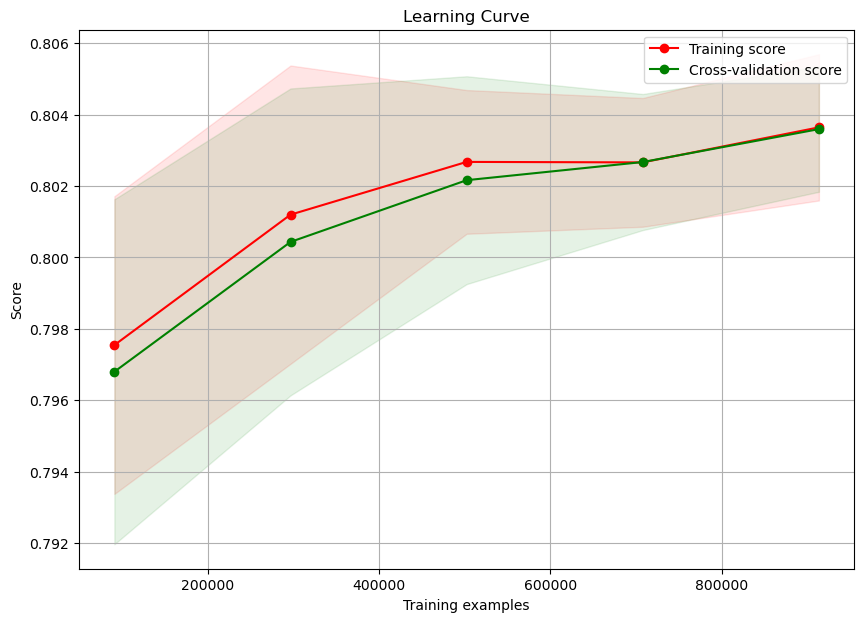

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(ann, X = x_train_control, y = y_train_control, ax=ax)

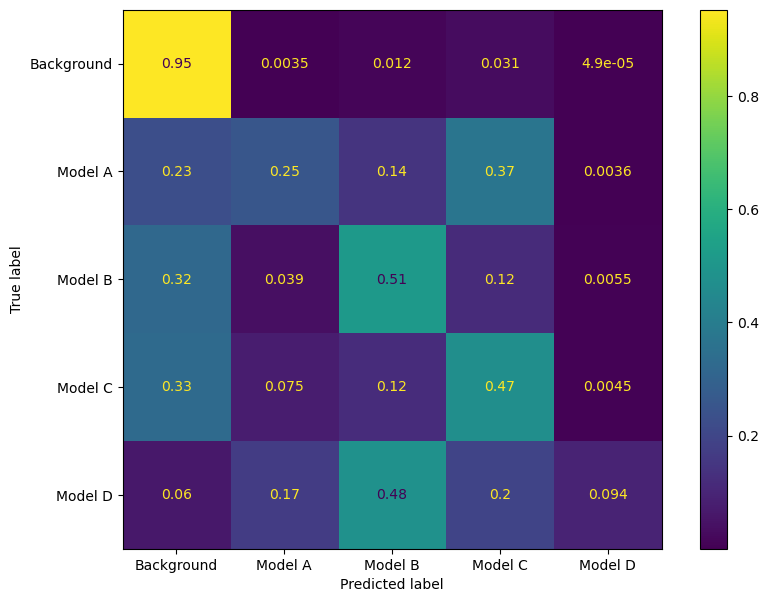

In [16]:
cm = confusion_matrix(y_test_control.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Binary

In [17]:
def build_clf():
    ann = Sequential()
    ann.add(Dense(units = 7, activation = 'relu'))
    ann.add(Dense(units = 28,#best_params['neurons'], 
                  activation = 'relu'))
    ann.add(Dense(units = 1, activation = 'sigmoid'))
    ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann

In [18]:
ann_bin = KerasClassifier(build_fn=build_clf)

In [21]:
ann_bin.fit(x_train_control, y_train_control_bin, 
        batch_size = 64, #best_params['batch_size'], 
        epochs = 5, 
        validation_split = 0.33)

Epoch 1/5
11950/11950 [==============================] - 12s 947us/step - loss: 0.3291 - accuracy: 0.8600 - val_loss: 0.3094 - val_accuracy: 0.8700
Epoch 2/5
11950/11950 [==============================] - 12s 968us/step - loss: 0.2955 - accuracy: 0.8780 - val_loss: 0.2941 - val_accuracy: 0.8793
Epoch 3/5
11950/11950 [==============================] - 11s 958us/step - loss: 0.2896 - accuracy: 0.8812 - val_loss: 0.2896 - val_accuracy: 0.8806
Epoch 4/5
11950/11950 [==============================] - 11s 951us/step - loss: 0.2881 - accuracy: 0.8818 - val_loss: 0.2886 - val_accuracy: 0.8816
Epoch 5/5
11950/11950 [==============================] - 11s 949us/step - loss: 0.2872 - accuracy: 0.8822 - val_loss: 0.2866 - val_accuracy: 0.8826


In [22]:
y_preds = ann_bin.predict(x_test_control)
precision = precision_score(y_test_control_bin, y_preds)
recall = recall_score(y_test_control_bin, y_preds)
f1 = f1_score(y_test_control_bin, y_preds)
accuracy = accuracy_score(y_test_control_bin, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

8922/8922 [==============================] - 5s 534us/step
Precision: 0.850
Recall: 0.716
F1: 0.777
Accuracy: 0.882


28537/28537 [==============================] - 17s 612us/step - loss: 0.2982 - accuracy: 0.8764


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

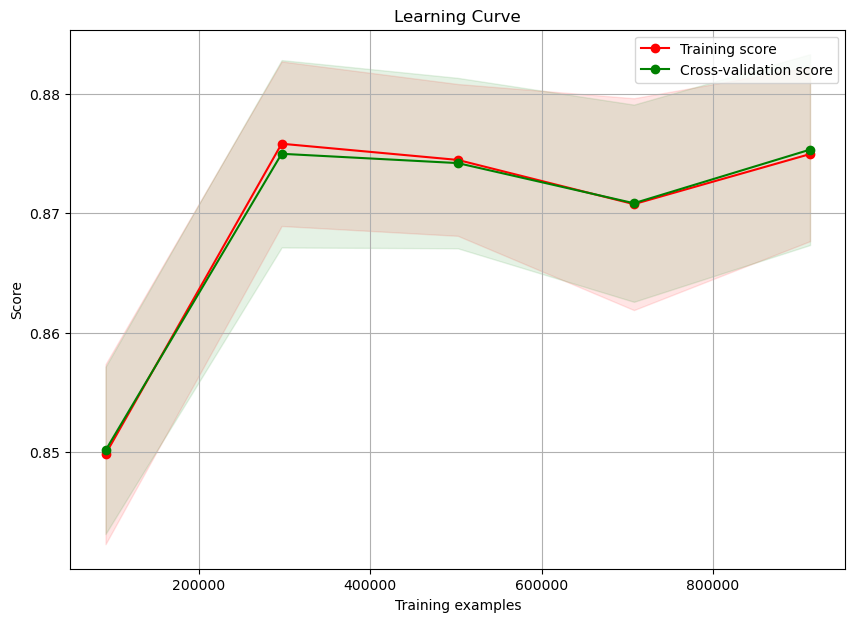

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(ann_bin, X = x_train_control, y = y_train_control_bin, ax=ax)

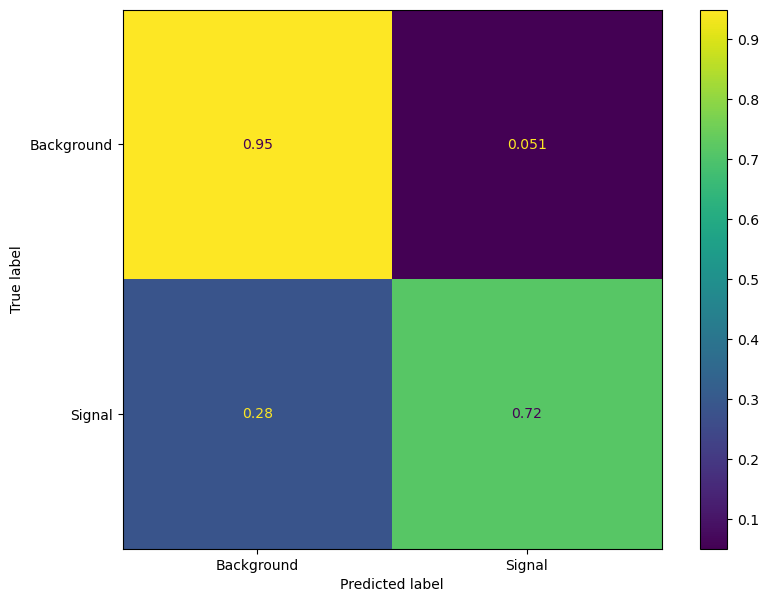

In [24]:
cm = confusion_matrix(y_test_control_bin.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Scores

8922/8922 [==============================] - 5s 523us/step


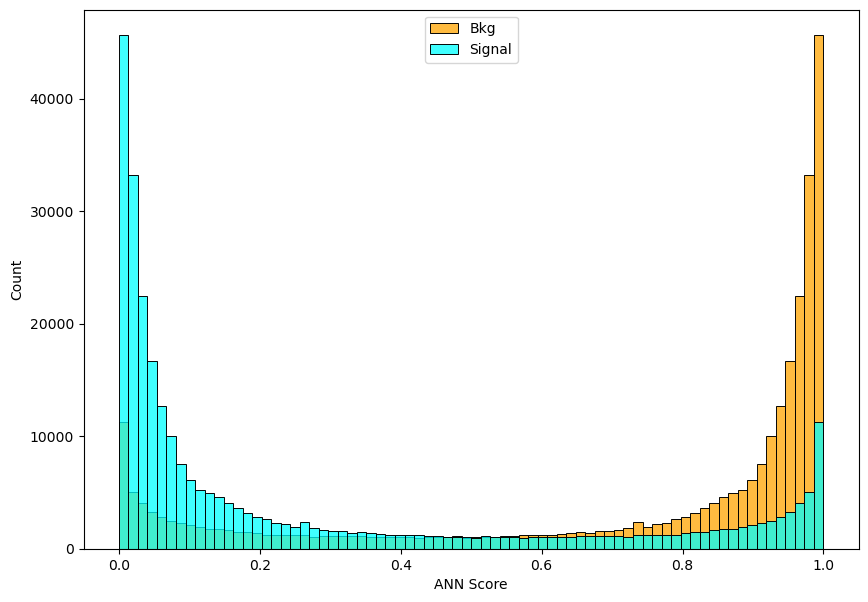

In [25]:
probs = ann_bin.predict_proba(x_test_control)
preds = probs[:, 1]

scaled = MinMaxScaler().fit_transform(probs)
plt.figure(figsize=(10,7))
sns.histplot(x=scaled[:,0], color='orange', label = 'Bkg', bins=100)
sns.histplot(x=scaled[:,1], color='cyan', label = 'Signal', bins=100)
plt.xlabel('ANN Score')
plt.legend()
plt.show()

[2, 3, 4]
8922/8922 [==============================] - 5s 514us/step
[0.00087712 0.00316583 0.11457457 ... 0.00105915 0.00027105 0.00053128]


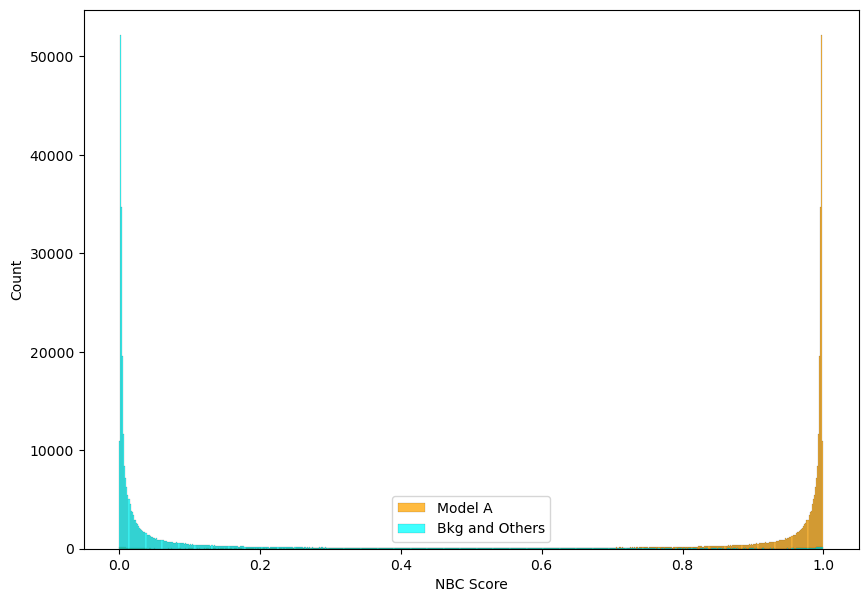

[1, 3, 4]
8922/8922 [==============================] - 5s 515us/step
[0.02920389 0.02655599 0.29275167 ... 0.01071605 0.01073674 0.12521954]


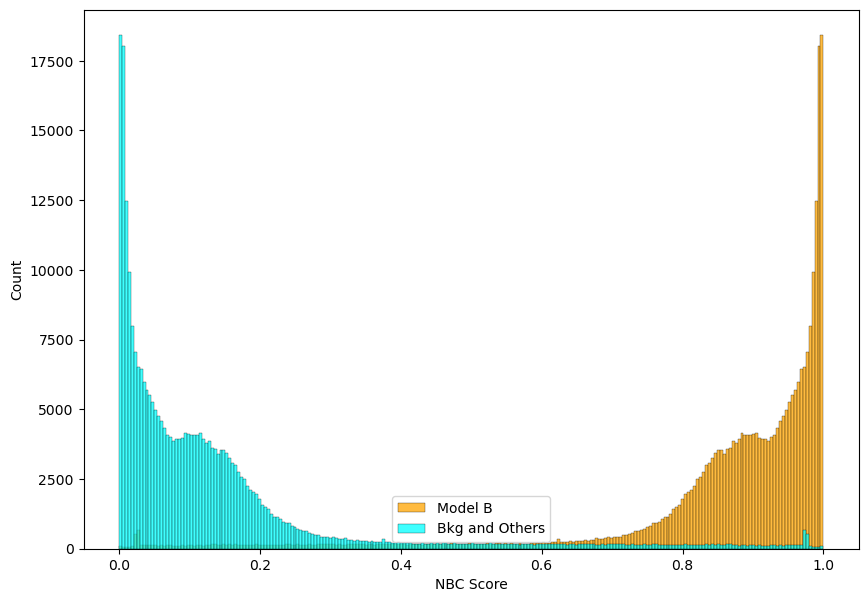

[1, 2, 4]
8922/8922 [==============================] - 5s 514us/step
[0.00434713 0.00948852 0.2575242  ... 0.00989588 0.00154547 0.4612226 ]


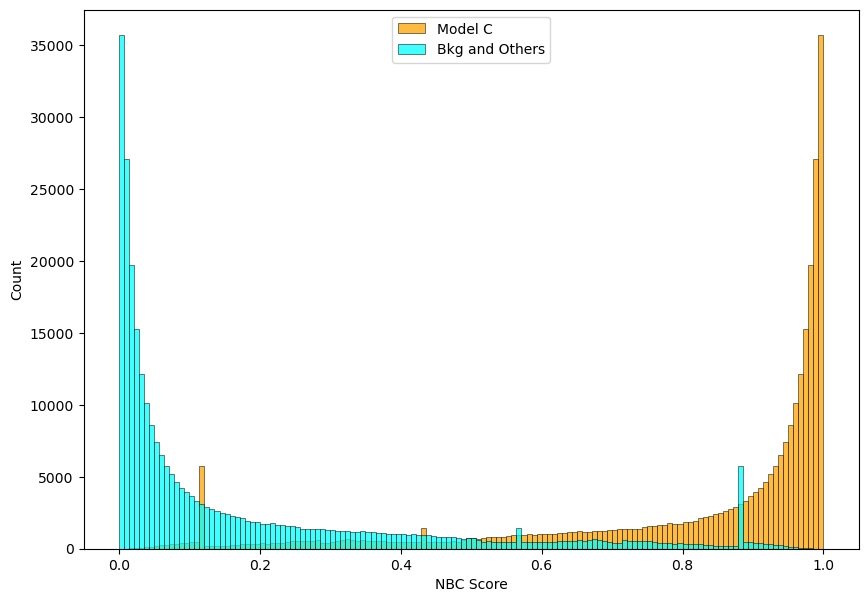

[1, 2, 3]
8922/8922 [==============================] - 5s 520us/step
[4.2778393e-04 1.7195035e-04 7.8714326e-02 ... 8.6084838e-05 2.7699248e-04
 2.3526546e-02]


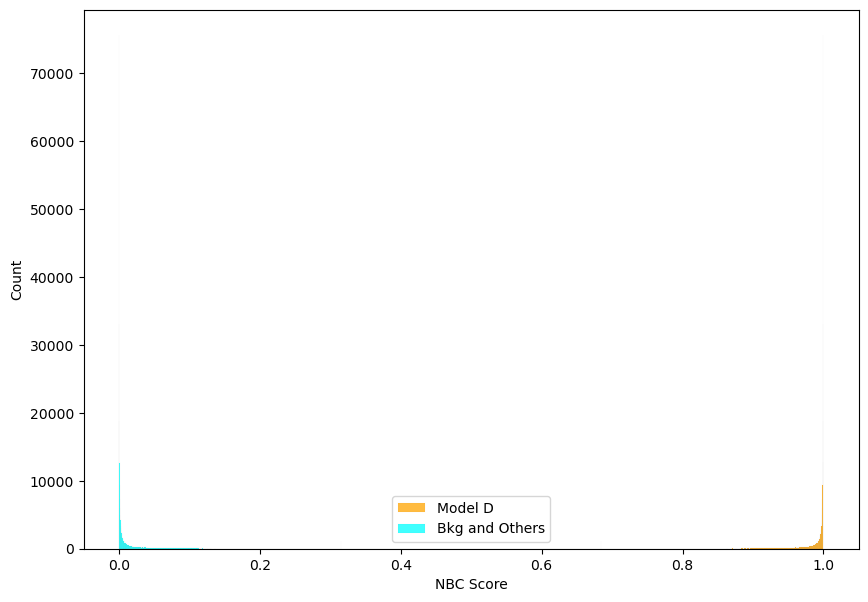

In [26]:
classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    #y_test_new = y_test.replace(to_replace=new, value=0)
    #y_test_new = y_test_new.replace(i, 1)
    y_train_new = y_train_control.replace(to_replace = new, value = 0)
    y_train_new = y_train_new.replace(i, 1)
    ann_bin.fit(x_train_control, y_train_new)
    probs = ann_bin.predict_proba(x_test_control)
    preds = probs[:, 1]
    print(preds)
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    sns.histplot(x=scaled[:,0], color='orange', label = 'Model %s'%models[i], bins=100)
    sns.histplot(x=scaled[:,1], color='cyan', label = 'Bkg and Others', bins=100)
    plt.xlabel('NBC Score')
    plt.legend()
    plt.show()

# ROC Curves

8922/8922 [==============================] - 5s 531us/step


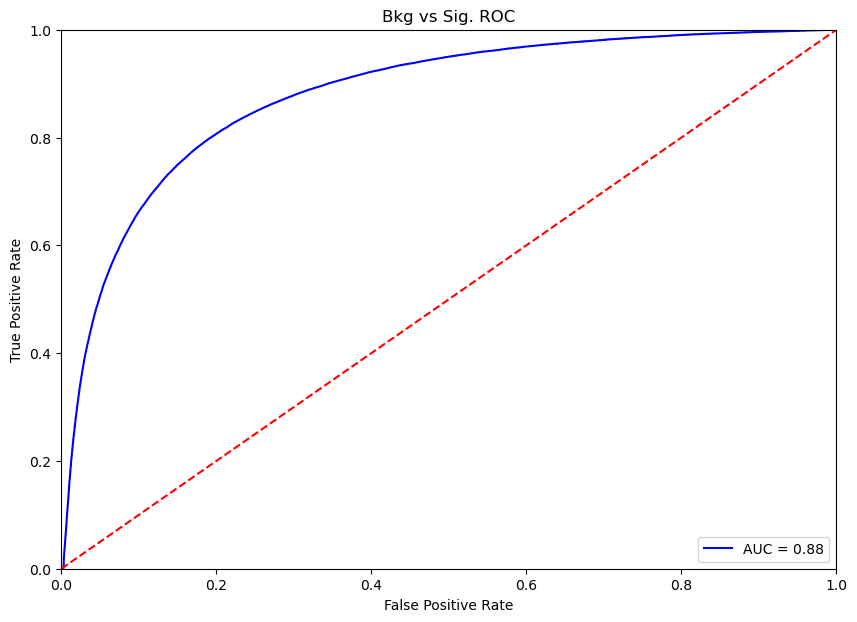

In [29]:
probs = ann_bin.predict_proba(x_test_control)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test_control_bin, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test_control.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    probs = ann.predict_proba(x_test_control)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

[2, 3, 4]
8922/8922 [==============================] - 5s 508us/step
[1, 3, 4]
8922/8922 [==============================] - 5s 503us/step
[1, 2, 4]
8922/8922 [==============================] - 5s 513us/step
[1, 2, 3]
8922/8922 [==============================] - 4s 502us/step


Model A optimum classification threshold: 0.048
Model B optimum classification threshold: 0.006
Model C optimum classification threshold: 0.017
Model D optimum classification threshold: 0.007


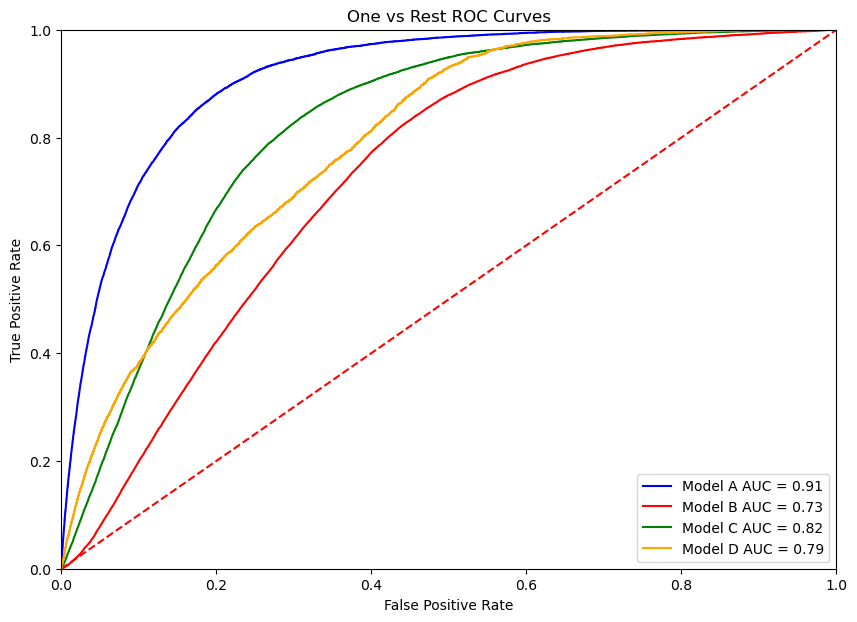

In [31]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('One vs Rest ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.show()

# Training on preselection, testing on control

In [10]:
def build_clf():
    ann = Sequential()
    ann.add(Dense(units = 7, activation = 'relu'))
    ann.add(Dense(units = 28, #best_params['neurons'], 
                  activation = 'relu'))
    ann.add(Dense(units = 5, activation = 'softmax'))
    ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return ann

In [11]:
ann = KerasClassifier(build_fn=build_clf)
ann.fit(x_train, y_train, 
        batch_size = 64, #best_params['batch_size'], 
        epochs = 5, 
        validation_split = 0.33)

Epoch 1/5
17316/17316 [==============================] - 18s 984us/step - loss: 0.7012 - accuracy: 0.7263 - val_loss: 0.6988 - val_accuracy: 0.7290
Epoch 2/5
17316/17316 [==============================] - 17s 975us/step - loss: 0.6862 - accuracy: 0.7318 - val_loss: 0.6887 - val_accuracy: 0.7287
Epoch 3/5
17316/17316 [==============================] - 17s 979us/step - loss: 0.6848 - accuracy: 0.7330 - val_loss: 0.6827 - val_accuracy: 0.7342
Epoch 4/5
17316/17316 [==============================] - 17s 965us/step - loss: 0.6838 - accuracy: 0.7331 - val_loss: 0.6803 - val_accuracy: 0.7347
Epoch 5/5
17316/17316 [==============================] - 17s 967us/step - loss: 0.6835 - accuracy: 0.7333 - val_loss: 0.6831 - val_accuracy: 0.7347


In [12]:
y_preds = ann.predict(x_test_control)
precision = precision_score(y_test_control, y_preds, average='weighted')
recall = recall_score(y_test_control, y_preds, average = 'weighted')
f1 = f1_score(y_test_control, y_preds, average = 'weighted')
accuracy = accuracy_score(y_test_control, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

8922/8922 [==============================] - 5s 510us/step
Precision: 0.512
Recall: 0.014
F1: 0.001
Accuracy: 0.014


41352/41352 [==============================] - 28s 680us/step - loss: 0.6936 - accuracy: 0.7283


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

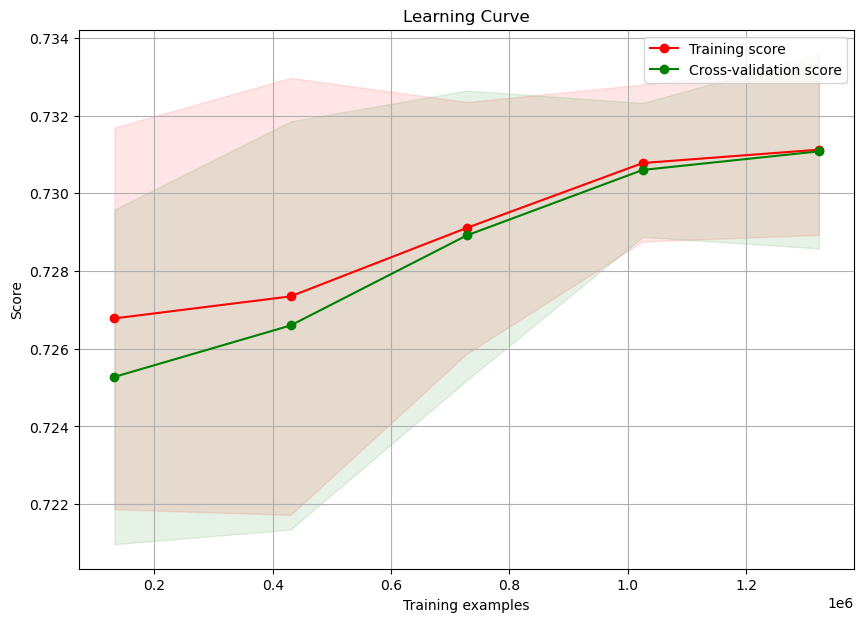

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(ann, X = x_train, y = y_train, ax=ax)

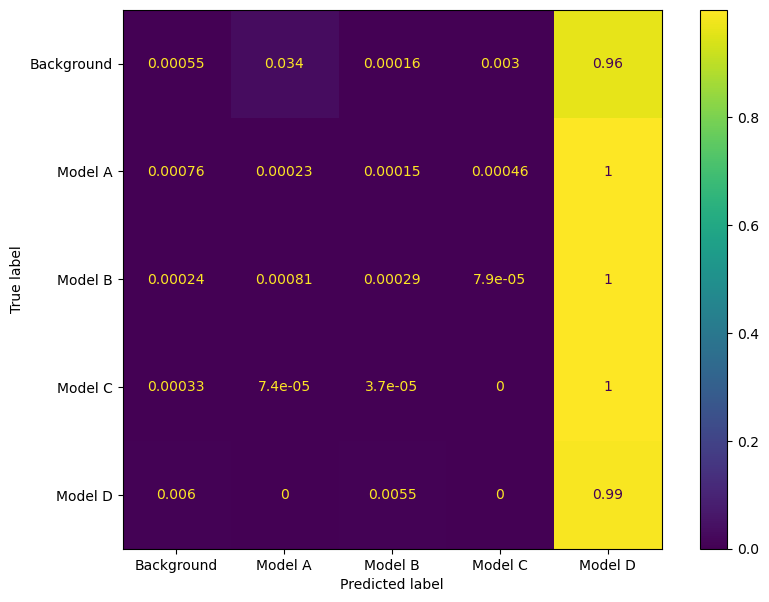

In [14]:
cm = confusion_matrix(y_test_control.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Binary

In [12]:
def build_clf():
    ann = Sequential()
    ann.add(Dense(units = 7, activation = 'relu'))
    ann.add(Dense(units = 28,#best_params['neurons'], 
                  activation = 'relu'))
    ann.add(Dense(units = 1, activation = 'sigmoid'))
    ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann

In [13]:
ann_bin = KerasClassifier(build_fn=build_clf)

In [14]:
ann_bin.fit(x_train, y_train_bin, 
        batch_size = 64, #best_params['batch_size'], 
        epochs = 5, 
        validation_split = 0.33)

Epoch 1/5
17316/17316 [==============================] - 17s 968us/step - loss: 0.2419 - accuracy: 0.9000 - val_loss: 0.2318 - val_accuracy: 0.9052
Epoch 2/5
17316/17316 [==============================] - 17s 969us/step - loss: 0.2202 - accuracy: 0.9108 - val_loss: 0.2164 - val_accuracy: 0.9127
Epoch 3/5
17316/17316 [==============================] - 17s 981us/step - loss: 0.2186 - accuracy: 0.9117 - val_loss: 0.2165 - val_accuracy: 0.9125
Epoch 4/5
17316/17316 [==============================] - 17s 963us/step - loss: 0.2180 - accuracy: 0.9120 - val_loss: 0.2185 - val_accuracy: 0.9115
Epoch 5/5
17316/17316 [==============================] - 17s 955us/step - loss: 0.2175 - accuracy: 0.9123 - val_loss: 0.2207 - val_accuracy: 0.9109


In [18]:
y_preds = ann_bin.predict(x_test_control)
precision = precision_score(y_test_control_bin, y_preds)
recall = recall_score(y_test_control_bin, y_preds)
f1 = f1_score(y_test_control_bin, y_preds)
accuracy = accuracy_score(y_test_control_bin, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

8922/8922 [==============================] - 5s 560us/step
Precision: 0.287
Recall: 0.999
F1: 0.446
Accuracy: 0.287


41352/41352 [==============================] - 24s 587us/step - loss: 0.2221 - accuracy: 0.9100


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

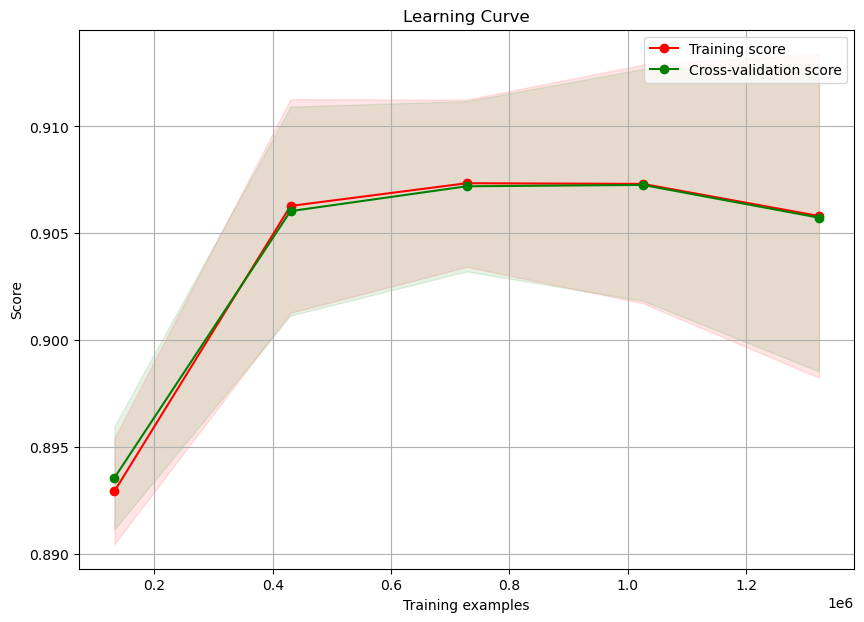

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(ann_bin, X = x_train, y = y_train_bin, ax=ax)

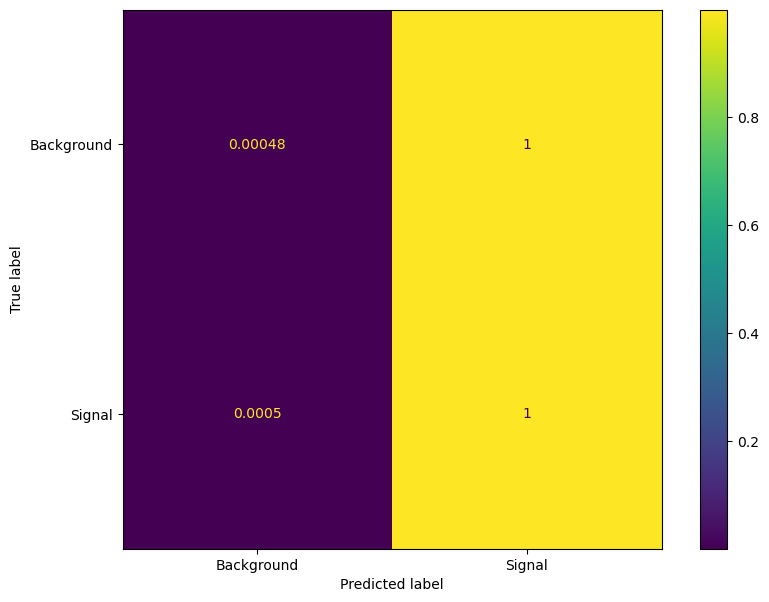

In [20]:
cm = confusion_matrix(y_test_control_bin.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Scores

8922/8922 [==============================] - 5s 517us/step


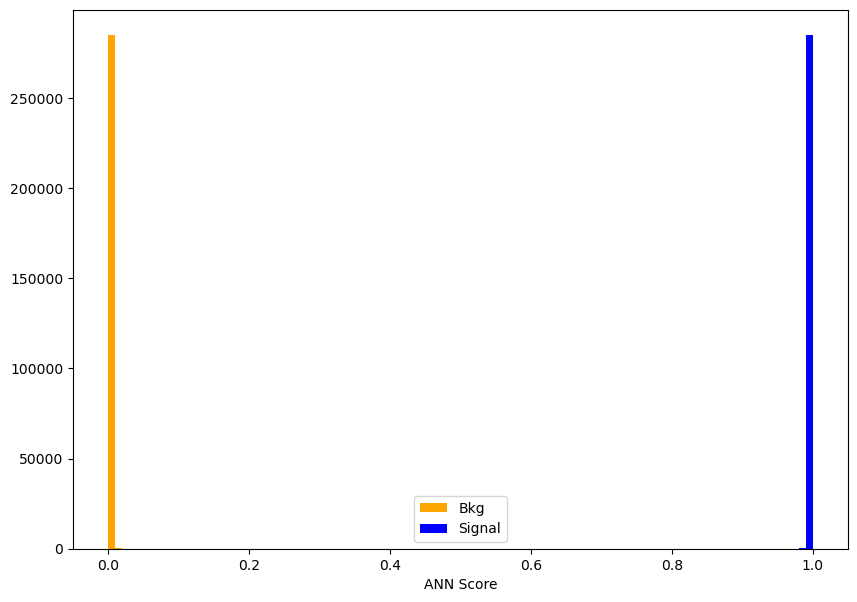

In [27]:
probs = ann_bin.predict_proba(x_test_control)
preds = probs[:, 1]

scaled = MinMaxScaler().fit_transform(probs)
plt.figure(figsize=(10,7))
plt.hist(x=scaled[:,0], color='orange', label = 'Bkg', bins=100)
plt.hist(x=scaled[:,1], color='blue', label = 'Signal', bins=100)
plt.xlabel('ANN Score')
plt.legend()
plt.savefig('plots/fixed_scores/ann_bin_scores_control_test.png')
plt.show()

classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    #y_test_new = y_test.replace(to_replace=new, value=0)
    #y_test_new = y_test_new.replace(i, 1)
    y_train_new = y_train.replace(to_replace = new, value = 0)
    y_train_new = y_train_new.replace(i, 1)
    ann_bin.fit(x_train, y_train_new)
    probs = ann_bin.predict_proba(x_test_control)
    preds = probs[:, 1]
    print(preds)
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    sns.histplot(x=scaled[:,0], color='orange', label = 'Model %s'%models[i], bins=100)
    sns.histplot(x=scaled[:,1], color='cyan', label = 'Bkg and Others', bins=100)
    plt.xlabel('NBC Score')
    plt.legend()
    plt.show()

1
410/410 [==============================] - 0s 529us/step


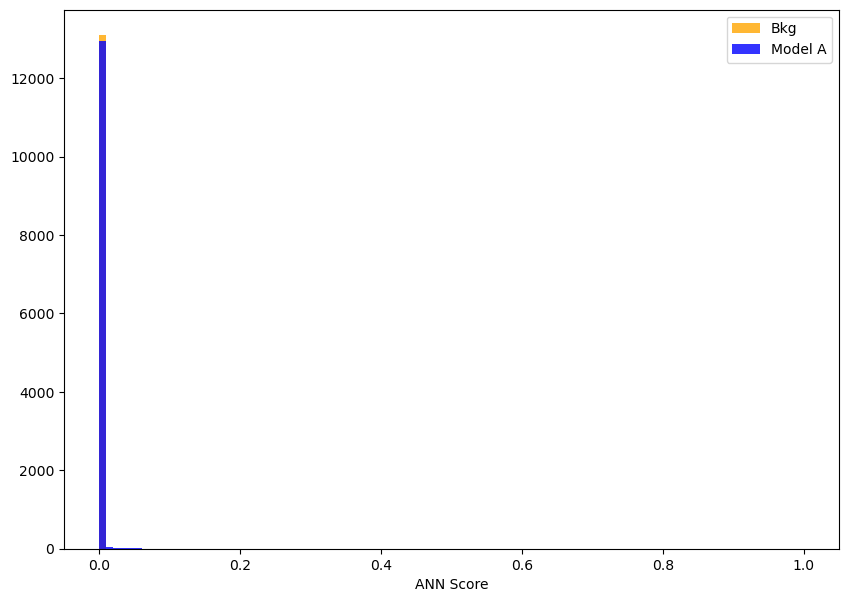

2
1192/1192 [==============================] - 1s 509us/step


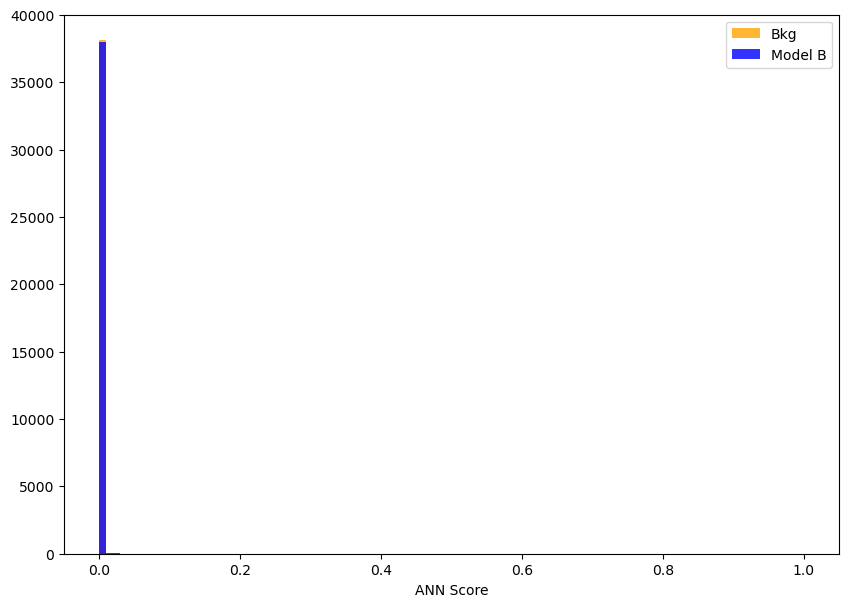

3
842/842 [==============================] - 0s 527us/step


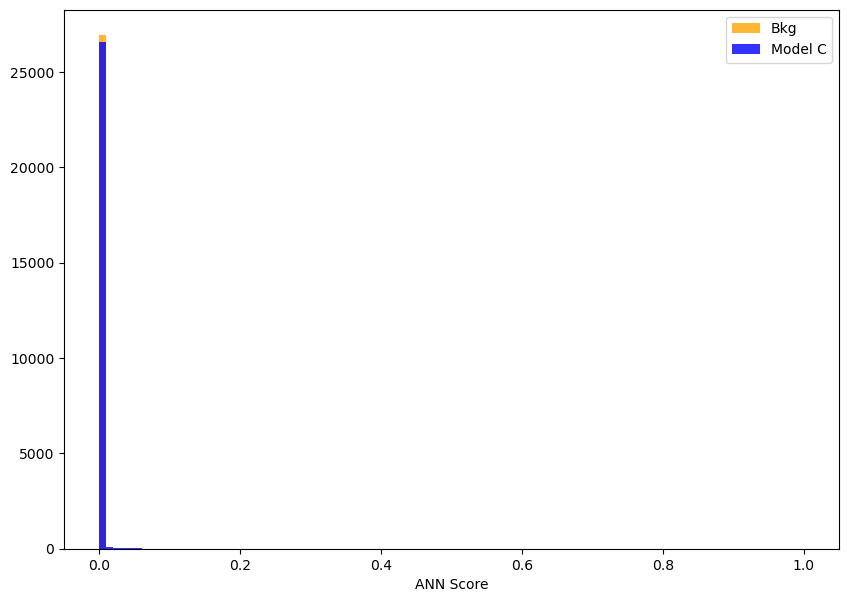

4
121/121 [==============================] - 0s 518us/step


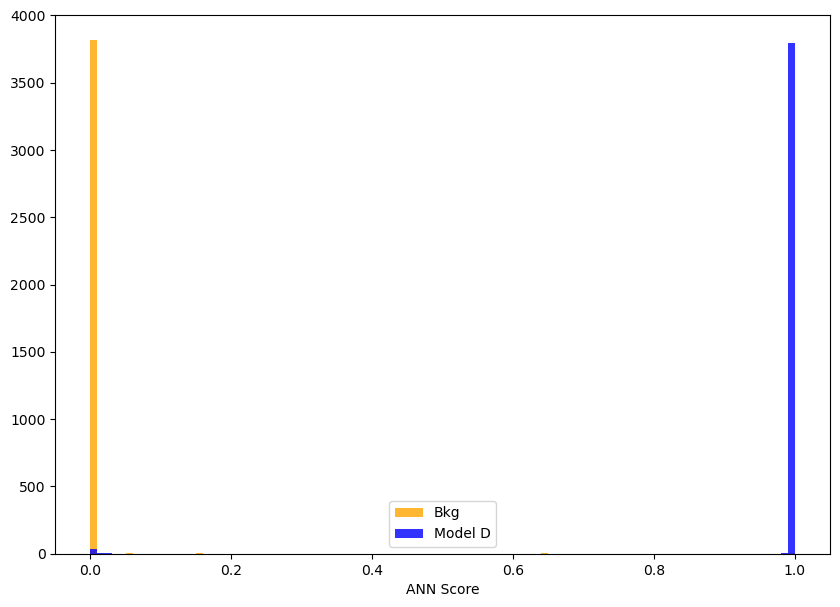

In [29]:
classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    print(i)
    test = np.array([x_test_control[j] for j in range(len(y_test_control)) if y_test_control.values[j] == i])
    probs = ann.predict_proba(test)
    
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    plt.hist(x=scaled[::,0], color='orange', label = 'Bkg', alpha = 0.8, bins = 100)
    plt.hist(x=scaled[::,i], color='blue', label = 'Model %s'%models[i], alpha = 0.8, bins = 100)
    plt.xlabel('ANN Score')
    plt.legend()
    plt.savefig('plots/fixed_scores/ann_bkg_vs_model%s_scores_control_test.png'%models[i])
    plt.show()

# ROC Curves

8922/8922 [==============================] - 5s 519us/step


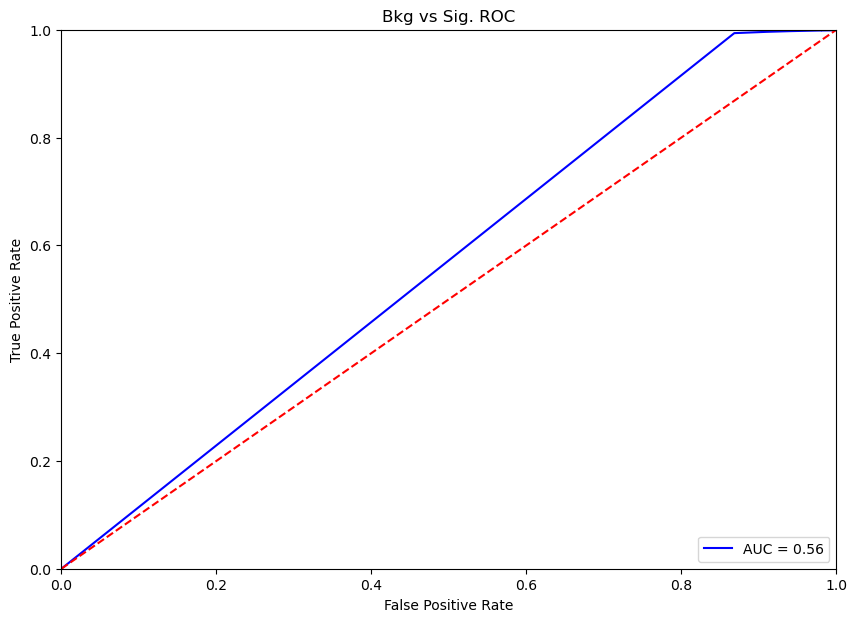

In [25]:
probs = ann_bin.predict_proba(x_test_control)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test_control_bin, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('plots/fixed_rocs/ann_bin_roc_control_test.png')
plt.show()

classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test_control.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    probs = ann.predict_proba(x_test_control)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

In [24]:
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    x_test_new = np.array([x_test_control[j] for j in range(len(y_test_control)) if (y_test_control.values[j] == i) or (y_test_control.values[j] == 0)])
    y_test_new = [k for k in y_test_control.values if (k==i) or (k==0)]
    probs = ann.predict_proba(x_test_new)
    preds = probs[:, i]
    fp, tp, thresh = roc_curve(y_test_new, preds, pos_label=i)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

6480/6480 [==============================] - 3s 533us/step


Model A optimum classification threshold: 0.000
Model B optimum classification threshold: 0.359
Model C optimum classification threshold: 1.805
Model D optimum classification threshold: 1.000


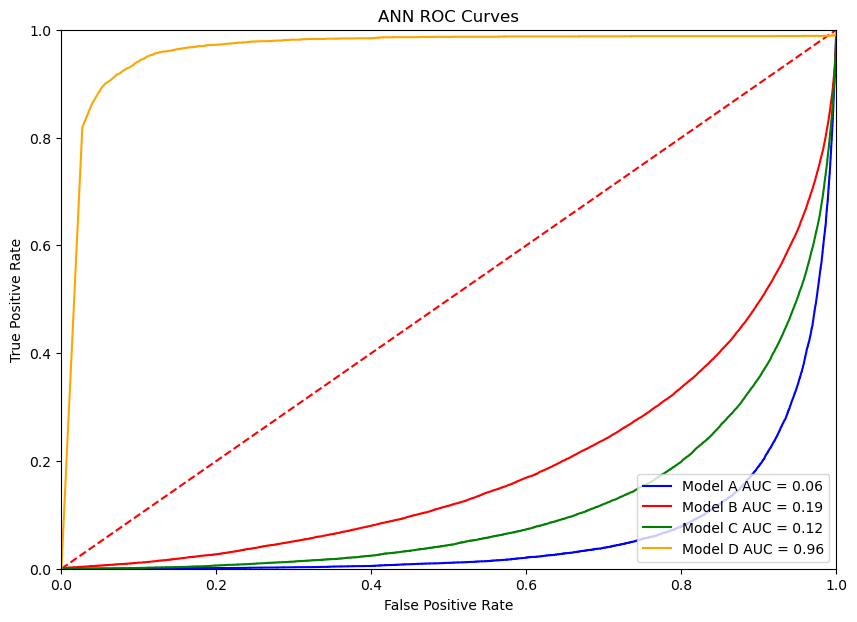

In [26]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('ANN ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.savefig('plots/fixed_rocs/ann_roc_control_test.png')
plt.show()